In [1]:
from import_images import getImages
import numpy as np
import torch
from cellpose import resnet_torch
from cellpose import transforms
import cv2
import time
from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchmetrics.classification import BinaryJaccardIndex
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\rz200\Anaconda3\envs\omero-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
def get_pre_activations(image,cpnet):

    print(cpnet.diam_mean, cpnet.diam_labels, cpnet.diam_mean/cpnet.diam_labels)
    image = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    print(image.shape)
    x = transforms.resize_image(image, rsz=cpnet.diam_mean/cpnet.diam_labels,no_channels=True).astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x).unsqueeze(0)

    downsample = cpnet.downsample(x)
    style = cpnet.make_style(downsample[-1])
    
    resized_downsample = []
    for tensor in downsample[0]:
        resized_tensor = F.interpolate(tensor.unsqueeze(0), size=(656, 656), mode='bilinear', align_corners=False)
        resized_tensor = resized_tensor.squeeze(0)
        resized_downsample.append(resized_tensor)
    downsample[0] = torch.stack(resized_downsample)

    print(downsample[0].shape, downsample[1].shape, downsample[2].shape, downsample[3].shape)
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample).squeeze(0)[2]
    output = output.cpu().detach().numpy()
    output = cv2.resize(output, dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(1024, 1024), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)

    return upsample, output

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image, upsample, cellprob):
        self.image = image
        self.upsample = upsample
        self.cellprob = cellprob

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        upsample = self.upsample[idx]
        cellprob = self.cellprob[idx]
        return img, upsample, cellprob
    
def get_crops(image,size):
    assert image.shape[0]%size == 0
    assert image.shape[0] == image.shape[1]
    crops = []
    for i in range(0,image.shape[0],size):
        for j in range(0,image.shape[1],size):
            crops.append(image[i:i+size,j:j+size])
    return crops

def reconstruct_image(crops, size):
    assert len(crops) > 0
    image_size = 1024
    size = 256
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    crop_idx = 0
    for i in range(0, image_size, size):
        for j in range(0, image_size, size):
            image[i:i+size, j:j+size] = crops[crop_idx]
            crop_idx += 1
    return image

def get_data(images, cpnet, crop_size=216):
    cp_upsamples = []
    cp_outputs = []
    for image in images:
        upsample, output = get_pre_activations(image,cpnet)
        cp_upsamples.append(upsample)
        cp_outputs.append(output)

    images_torch = torch.from_numpy(np.array(images, dtype=np.float32))
    train_images, test_images, train_upsamples, test_upsamples, train_cellprob, test_cellprob = train_test_split(images_torch, cp_upsamples, cp_outputs, test_size=0.1, random_state=42)
    
    #print(train_images[0].shape, train_upsamples[0].shape, train_cellprob[0].shape)

    images_normalised = []
    for image in train_images:
        min_val = torch.min(image)
        max_val = torch.max(image)
        normalized_image = (image - min_val) / (max_val - min_val)
        images_normalised.append(normalized_image)

    images_torch_rotated = []
    for image in images_normalised:
        images_torch_rotated.append(image)
        for i in range(3):
            image = torch.rot90(image, 1, [0, 1])
            images_torch_rotated.append(image)

    images_torch_rotated_flipped = []
    for image in images_torch_rotated:
        images_torch_rotated_flipped.append(image)
        images_torch_rotated_flipped.append(torch.flip(image, [1]))

    cp_upsamples_normalised = []
    for upsample in train_upsamples:
        min_val = np.min(upsample)
        max_val = np.max(upsample)
        normalized_upsample = (upsample - min_val) / (max_val - min_val)
        cp_upsamples_normalised.append(normalized_upsample)

    cp_upsamples_rotated = []
    for upsample in cp_upsamples_normalised:
        cp_upsamples_rotated.append(upsample)
        for i in range(3):
            upsample = np.rot90(upsample, 1, [1, 2])
            cp_upsamples_rotated.append(upsample)

    cp_upsamples_rotated_flipped = []
    for upsample in cp_upsamples_rotated:
        cp_upsamples_rotated_flipped.append(upsample)
        cp_upsamples_rotated_flipped.append(np.flip(upsample, [2]))

    cp_outputs_rotated = []
    for output in train_cellprob:
        cp_outputs_rotated.append(output)
        for i in range(3):
            output = np.rot90(output, 1, [0, 1])
            cp_outputs_rotated.append(output)

    cp_outputs_rotated_flipped = []
    for output in cp_outputs_rotated:
        cp_outputs_rotated_flipped.append(output)
        cp_outputs_rotated_flipped.append(np.flip(output, [1]))

    images_cropped = []
    for image in images_torch_rotated_flipped:
        #print(image.shape)
        crops = get_crops(image,crop_size)
        for crop in crops:
            images_cropped.append(crop)

    cp_upsampled_cropped = []
    for (i,upsample) in enumerate(cp_upsamples_rotated_flipped):
        crops_per_chan = []
        for chan in upsample:
            chan = cv2.resize(chan, dsize=(1080, 1080), interpolation=cv2.INTER_CUBIC)
            crops = get_crops(chan,crop_size)
            crops_per_chan.append(crops)

        for j in range(25):
            crop_channels_of_crop = []
            for k in range(32):
                crop_channels_of_crop.append(crops_per_chan[k][j])
            crop_channels_of_crop = np.array(crop_channels_of_crop)
            crop_channels_of_crop = crop_channels_of_crop.copy()
            crop_channels_of_crop = torch.from_numpy(crop_channels_of_crop)
            cp_upsampled_cropped.append(crop_channels_of_crop)

    cp_outputs_cropped = []
    for output in cp_outputs_rotated_flipped:
        output = cv2.resize(output, dsize=(1080, 1080), interpolation=cv2.INTER_CUBIC)
        crops = get_crops(output,crop_size)
        for crop in crops:
            crop = torch.from_numpy(crop.copy())
            cp_outputs_cropped.append(crop)

    return images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_images, test_upsamples, test_cellprob

In [5]:
class KD_loss(torch.nn.Module):
    def __init__(self, alpha, beta):
        super(KD_loss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_32_pred, y_32_true, y_3_pred, y_3_true):
        
        #32-channel loss
        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        #3-channel loss
        y_3_bce_loss = F.mse_loss(y_3_pred, y_3_true.float())

        return y_32_loss * self.alpha, y_3_bce_loss * self.beta

In [6]:
def trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler, epoch_num, device):
    time_start = time.time()
    
    unet.train()

    train_y_32_loss, train_map_loss = 0, 0

    for image, upsample, cp_output in train_loader:

        if device == 'mps':
            image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        train_y_32_loss += loss_32.item()
        train_map_loss += loss_map.item()

         # zero out the accumulated gradients

        #I want to get two losses, one for the 32-channel output and one for the 3-channel output
        #I then want to freeze certain channels before putting the losses backwards
        unet.encoder.requires_grad = True #repetitive but just to be clear
        unet.decoder.requires_grad = True
        unet.head.requires_grad = False
        loss_32.backward(retain_graph=True)

        
        unet.encoder.requires_grad = False
        unet.decoder.requires_grad = False
        unet.head.requires_grad = True
        loss_map.backward(retain_graph=True)

        optimiser.step() # update model parameters
        optimiser.zero_grad()

    if scheduler is not None:
        scheduler.step()

    train_y_32_loss, train_map_loss = train_y_32_loss/len(train_loader), train_map_loss/len(train_loader)


    val_y_32_loss, val_map_loss, val_IoU = 0, 0, 0
    for image, upsample, cp_output in validation_loader:
        if device == 'mps':
            image, upsample, cp_output = image.float(), upsample.float(), cp_output.float() #cast to float32 (important for mps)

        if device is not None:
            (image, upsample, cp_output) = (image.to(device),upsample.to(device),cp_output.to(device)) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_16_pred, y_32_pred, map_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        map_pred = map_pred.squeeze(1)
    
        loss_32, loss_map = loss_fn(y_32_pred,  upsample, map_pred, cp_output) # calculate the loss of that prediction
        val_y_32_loss += loss_32.item()
        val_map_loss += loss_map.item()

        #IoU score
        jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
        map_pred = F.sigmoid(map_pred)
        cp_output = F.sigmoid(cp_output)
        cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
        iou = jaccard(map_pred, cp_output)
        if not torch.isnan(iou):
            val_IoU += iou
        else:
            val_IoU += 0
        

    val_y_32_loss, val_map_loss, val_IoU = val_y_32_loss/len(validation_loader), val_map_loss/len(validation_loader), val_IoU.item()/len(validation_loader)
    
    #we might add displaying later on
    
    if epoch_num is None:
        print('Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)
    else:
        print('Epoch: ', epoch_num, 'Train 32 loss: ', train_y_32_loss,'Train map loss', train_map_loss, 'Val 32 loss: ', val_y_32_loss, 'Val map loss: ', val_map_loss, 'Val IoU: ', val_IoU, 'Time: ', time.time()-time_start)

    return unet

In [7]:
import ezomero
from omero_data import connect, extract_channel, progressbar

conn = connect(user='rz200',password='omeroreset')

plate = 1237
image_ids = ezomero.get_image_ids(conn,plate=plate)

print('In plate',plate,'we have',len(image_ids),'images')

data_images = []
for i in progressbar(range(len(image_ids)), "Computing: ", 40):
    data_images.append(ezomero.get_image(conn, image_ids[i])[1])

data_images_one = extract_channel(data_images, 0)
data_images_two = extract_channel(data_images, 1)


Connection successful
In plate 1237 we have 36 images
Computing: [########################################] 36/36



In [8]:
#images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
#images_directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/pipeline/uploads"
#file_names, images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(data_images_one, dtype=np.float32)).unsqueeze(0)

#directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
#directory = "/Users/rehanzuberi/Documents/Development/distillCellSegTrack/datasets/Fluo-C2DL-Huh7/01/models/CP_20230601_101328"
directory = "/Users/rz200/Documents/development/distillCellSegTrack/pipeline/CellPose_models/Nuclei_Hoechst"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [9]:
print(cpnet.diam_labels)

Parameter containing:
tensor([13.2426])


In [10]:
images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_images, test_upsamples, test_cellprob = get_data(data_images_one[:4], cpnet)

Parameter containing:
tensor([17.]) Parameter containing:
tensor([13.2426]) tensor([1.2837])
(512, 512)
torch.Size([1, 32, 656, 656]) torch.Size([1, 64, 328, 328]) torch.Size([1, 128, 164, 164]) torch.Size([1, 256, 82, 82])
Parameter containing:
tensor([17.]) Parameter containing:
tensor([13.2426]) tensor([1.2837])
(512, 512)
torch.Size([1, 32, 656, 656]) torch.Size([1, 64, 328, 328]) torch.Size([1, 128, 164, 164]) torch.Size([1, 256, 82, 82])
Parameter containing:
tensor([17.]) Parameter containing:
tensor([13.2426]) tensor([1.2837])
(512, 512)
torch.Size([1, 32, 656, 656]) torch.Size([1, 64, 328, 328]) torch.Size([1, 128, 164, 164]) torch.Size([1, 256, 82, 82])
Parameter containing:
tensor([17.]) Parameter containing:
tensor([13.2426]) tensor([1.2837])
(512, 512)
torch.Size([1, 32, 656, 656]) torch.Size([1, 64, 328, 328]) torch.Size([1, 128, 164, 164]) torch.Size([1, 256, 82, 82])


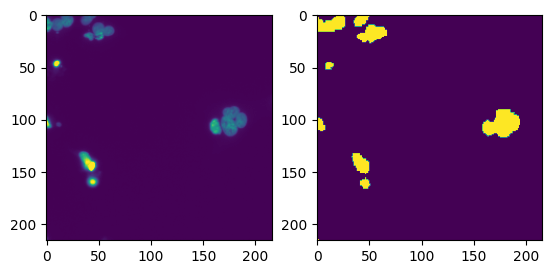

In [11]:
plt.subplot(1,2,1)
plt.imshow(images_cropped[8])
plt.subplot(1,2,2)
plt.imshow(cp_outputs_cropped[8]>0.5)
plt.show()

In [12]:
train_images, val_images, train_upsamples, val_upsamples, train_cellprob, val_cellprob = train_test_split(images_cropped, cp_upsampled_cropped, cp_outputs_cropped, test_size=0.1, random_state=42)

num_train_images = 10
train_dataset = ImageDataset(images_cropped, cp_upsampled_cropped, cp_outputs_cropped)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

validation_dataset = ImageDataset(val_images, val_upsamples, val_cellprob)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

test_dataset = ImageDataset(test_images, test_upsamples, test_cellprob)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [13]:
unet = UNet(encChannels=(1,32,64,128,256),decChannels=(256,128,64,32),nbClasses=1)
unet = unet.to('cuda:0')
#unet.state_dict(torch.load('C:/Users/rz200/Documents/development/distillCellSegTrack/pipeline/unet_nuclei_hoechst_test_1'))

In [14]:
loss_fn = KD_loss(alpha=1, beta=1)
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)

#I think a decaying scheduler is best, not a cyclic one
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.000001, max_lr=0.1)

for epoch in range(500):
    #print(scheduler.get_last_lr())
    unet = trainEpoch(unet, train_loader, test_loader, validation_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch, device='cuda:0')

c:\Users\rz200\Anaconda3\envs\omero-env\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  0 Train 32 loss:  0.03122119590640068 Train map loss 60.96837153116862 Val 32 loss:  0.031183999497443438 Val map loss:  59.298277854919434 Val IoU:  0.12147955596446991 Time:  55.87609624862671
Epoch:  1 Train 32 loss:  0.031091856931646664 Train map loss 41.513522211710615 Val 32 loss:  0.03102178988046944 Val map loss:  27.051238536834717 Val IoU:  0.6072366237640381 Time:  55.20483589172363
Epoch:  2 Train 32 loss:  0.03097545030216376 Train map loss 13.19212719599406 Val 32 loss:  0.031131281750276685 Val map loss:  5.846451818943024 Val IoU:  0.6084000468254089 Time:  56.91037583351135
Epoch:  3 Train 32 loss:  0.03120124523838361 Train map loss 4.577097476323446 Val 32 loss:  0.03144099679775536 Val map loss:  4.708073318004608 Val IoU:  0.5959469079971313 Time:  57.22371482849121
Epoch:  4 Train 32 loss:  0.03151979809006055 Train map loss 4.306321938832601 Val 32 loss:  0.03160514519549906 Val map loss:  4.689477860927582 Val IoU:  0.6106187701225281 Time:  57.75616002

KeyboardInterrupt: 

In [124]:
import gc
torch.cuda.empty_cache()
gc.collect()


11821

In [15]:
torch.save(unet.state_dict(), 'unet_nuclei_hoechst_test_2')

In [ ]:
#git commit -m "figured out it was the U20S cellpose model used in the Omero screen script at least for the first segmentation
#but it gave me some not very good segmentations on the plate when trying it on two_step_dist_3 even though it is supposed to
#be optimised for that plate so will have to check when we run the cell analysis results otherw^X

In [ ]:
#now need to add post-processing and prediction functions and show some tests data
#then will need to add the random seed weight test

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
!nvidia-smi

Tue Jun 27 13:50:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P1000       WDDM  | 00000000:01:00.0  On |                  N/A |
| 38%   50C    P8    N/A /  N/A |    823MiB /  4096MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
val_IoU = 0
for image, upsample, cp_output in validation_loader:
    print('x')
    (image, upsample, cp_output) = (image.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

    image = image.unsqueeze(1)
    y_16_pred, y_32_pred, map_pred = unet(image)
    y_32_pred = y_32_pred.squeeze(1)
    map_pred = map_pred.squeeze(1)

    device = 'cuda:0'
    #IoU score
    jaccard = BinaryJaccardIndex(threshold=0.5).to(device)
    map_pred = F.sigmoid(map_pred)
    cp_output = F.sigmoid(cp_output)
    cp_output = torch.where(cp_output > 0.5, 1.0, 0.0)
    iou = jaccard(map_pred, cp_output)
    if not torch.isnan(iou):
        val_IoU += iou
    else:
        val_IoU += 0

    break

x


torch.Size([8, 216, 216])


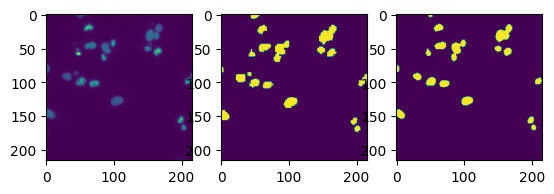

[False  True]


In [19]:
plt.subplot(1,3,1)
plt.imshow(image.squeeze(0).cpu().detach().numpy()[0][0])

print(cp_output.shape)
cp_output = cp_output.squeeze(0)
cp_output = cp_output.cpu().detach().numpy()
plt.subplot(1,3,2)
plt.imshow(cp_output[0])

map_pred = map_pred.squeeze(0)
map_pred = map_pred.cpu().detach().numpy()
map_pred = map_pred[0] > 0.5
plt.subplot(1,3,3)
plt.imshow(map_pred)
plt.show()

print(np.unique(map_pred))

In [20]:
print(np.unique(map_pred, return_counts=True))

(array([False,  True]), array([44459,  2197], dtype=int64))


In [291]:
from skimage import measure
from skimage import measure, color, io

#map_pred_0 = map_pred.squeeze(0)
#map_pred_0 = map_pred_0.cpu().detach().numpy()
#map_pred_0 = map_pred_0[0] > 0.5

#img = np.load('test.npy').astype(np.int32) # the method only works with 32bit image

map_pred_0 = map_pred.astype(np.uint8)

ret1, thresh = cv2.threshold(map_pred_0, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

sure_bg = cv2.dilate(opening,kernel,iterations=10)

dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

ret2, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
ret3, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
#markers = markers.astype(np.uint8)
print(map_pred_0.shape, markers.shape)
markers = cv2.watershed(map_pred_0, markers)
map_pred_0[markers == -1] = [0,255,255]  

img2 = color.label2rgb(markers, bg_label=0)

print(np.unique(img2))
plt.imshow(img2)
plt.show()

(216, 216) (216, 216)


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'cv::watershed'


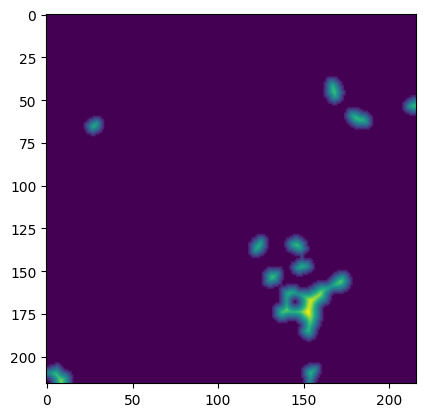

[-1  1  2  3  4  5  6  7  8  9 10 11 12]


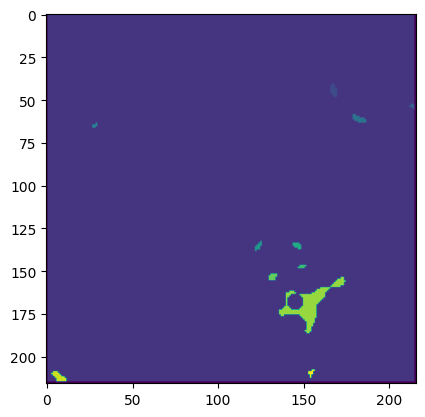

In [341]:
image = map_pred.astype(np.uint8)

image = cv2.morphologyEx(image, cv2.MORPH_OPEN,
        np.ones((3, 3), dtype=int))

#gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
#ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#kernel = np.ones((3,3),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

#plt.subplot(1,2,1)
#plt.imshow(image)
#plt.imshow(opening);plt.show()

# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=1)
# Finding sure foreground area

dist_transform = cv2.distanceTransform(image,cv2.DIST_L2,5)
plt.imshow(dist_transform); plt.show()


ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

#plt.imshow(thresh)

ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
markers = cv2.watershed(image,markers)
image[markers == -1] = [0,255,255]
image = color.label2rgb(markers, bg_label=0)

print(np.unique(markers))
plt.imshow(markers);plt.show()

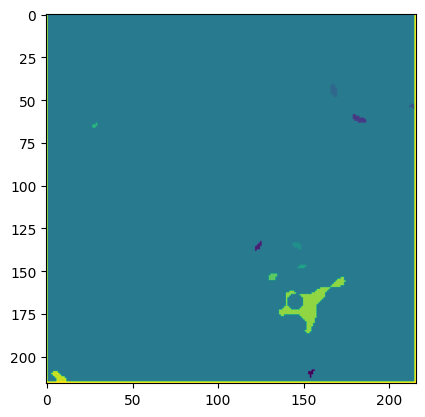

In [413]:
import sys
import cv2
from scipy.ndimage import label


def segment_on_dt(a, img):
    border = cv2.dilate(img, None, iterations=1)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 130, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now. 
    lbl[border == 255] = 255

    lbl = lbl.astype(np.int32)
    a = cv2.cvtColor(a,cv2.COLOR_GRAY2RGB)
    cv2.watershed(a, lbl)

    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)
    return 255 - lbl

image = map_pred.astype(np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN,np.ones((1, 1), dtype=int))
result = segment_on_dt(image, image)

result[result == np.max(result)] = 0
result[result == np.max(result)] = 0
unique_values = np.unique(result)  # Find the unique values in the array
sorted_values = np.sort(unique_values)  # Sort the unique values
value_index_map = {value: index for index, value in enumerate(sorted_values)}
ordered_array = np.vectorize(lambda x: value_index_map[x])(result)
print(np.unique(ordered_array, return_counts=True))
plt.imshow(ordered_array);plt.show()

In [22]:
from scipy.ndimage import label

def segment_on_dt(img):

    image = img.astype(np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN,np.ones((1, 1), dtype=int))

    a = image
    img = image

    border = cv2.dilate(img, None, iterations=1)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 130, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now. 
    lbl[border == 255] = 255

    lbl = lbl.astype(np.int32)
    a = cv2.cvtColor(a,cv2.COLOR_GRAY2RGB)
    cv2.watershed(a, lbl)

    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)

    result = 255 - lbl

    result[result == np.max(result)] = 0
    result[result == np.max(result)] = 0
    unique_values = np.unique(result)  # Find the unique values in the array
    sorted_values = np.sort(unique_values)  # Sort the unique values
    value_index_map = {value: index for index, value in enumerate(sorted_values)}
    ordered_array = np.vectorize(lambda x: value_index_map[x])(result)

    return ordered_array

result = segment_on_dt(map_pred)

In [98]:
#we need to define a test notebook to show how we just import the model and use its prediction function that takes returns the full instance segmentation

#process of raw image to instance segmentation
#1. image is normalised
def normalise_image(image):
    #check if the values of the image are between 0 and 1, if they are not, normalise them between 0 and 1
    if np.max(image) > 1:
        min_val = np.min(image)
        max_val = np.max(image)
        image = (image - min_val) / (max_val - min_val)
    return image

#2. image is cut up into overlapping 256x256 tiles
def cut_image_into_tiles(image):
    height, width = image.shape[:2]
    tile_size = 216
    overlap = tile_size // 2

    # Calculate the number of tiles needed in each dimension
    num_tiles_vertical = int(np.ceil(height / (tile_size - overlap)))
    num_tiles_horizontal = int(np.ceil(width / (tile_size - overlap)))

    # Calculate the padding required for the image
    pad_height = num_tiles_vertical * (tile_size - overlap) + overlap
    pad_width = num_tiles_horizontal * (tile_size - overlap) + overlap

    # Pad the image
    padded_image = np.pad(image, ((0, pad_height - height), (0, pad_width - width)), mode='constant')

    # Create an empty array to store the tiles
    tiles = np.empty((num_tiles_vertical, num_tiles_horizontal, tile_size, tile_size), dtype=image.dtype)

    # Generate the tiles
    for i in range(num_tiles_vertical):
        for j in range(num_tiles_horizontal):
            y_start = i * (tile_size - overlap)
            y_end = y_start + tile_size
            x_start = j * (tile_size - overlap)
            x_end = x_start + tile_size
            tiles[i, j] = padded_image[y_start:y_end, x_start:x_end]

    return tiles, height, width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap
    
#3. tiles are fed into model
def predict_tiles(model, tiles):
    model.eval()

    predictions = []
    for col in tiles:
        col_preds = []
        for tile in col:
            tile = torch.from_numpy(np.float32(tile)).unsqueeze(0).unsqueeze(0).float()
            tile = tile.to('cuda:0')
            _, _, pred = model(tile)
            pred = pred.cpu().detach().numpy().squeeze()
            col_preds.append(pred)
        col_preds = np.array(col_preds)
        predictions.append(col_preds)
    predictions = np.array(predictions)
    return predictions

#4. binary segmentation is stitched back together
def reassemble_tiles(tiles, original_img_height, original_img_width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap):
    # Create an empty array to store the reassembled image
    reassembled_image = np.empty((pad_height, pad_width))

    # Generate the reassembled image by averaging overlapping tiles
    for i in range(num_tiles_vertical):
        for j in range(num_tiles_horizontal):
            y_start = i * (tile_size - overlap)
            y_end = y_start + tile_size
            x_start = j * (tile_size - overlap)
            x_end = x_start + tile_size
            reassembled_image[y_start:y_end, x_start:x_end] = tiles[i, j]

    # Crop the padded regions from the reassembled image
    cropped_image = reassembled_image[:original_img_height, :original_img_width]

    return cropped_image

#5. binary segmentation is converted to instance segmentation
def binary_to_instance(img):
    image = img.astype(np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN,np.ones((1, 1), dtype=int))

    a = image
    img = image

    border = cv2.dilate(img, None, iterations=1)
    border = border - cv2.erode(border, None)

    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, 130, 255, cv2.THRESH_BINARY)
    lbl, ncc = label(dt)
    lbl = lbl * (255 / (ncc + 1))
    # Completing the markers now. 
    lbl[border == 255] = 255

    lbl = lbl.astype(np.int32)
    a = cv2.cvtColor(a,cv2.COLOR_GRAY2RGB)
    cv2.watershed(a, lbl)

    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)

    result = 255 - lbl

    #find the most frequent value in the array and set it to zero
    unique_values, counts = np.unique(result, return_counts=True)
    sorted_indices = np.argsort(counts)
    most_frequent_values = unique_values[sorted_indices[-2:]]
    result[np.isin(result, most_frequent_values)] = 0


    #result[result == np.max(result)] = 0
    #result[result == np.max(result)] = 0
    unique_values = np.unique(result)  # Find the unique values in the array
    sorted_values = np.sort(unique_values)  # Sort the unique values
    value_index_map = {value: index for index, value in enumerate(sorted_values)}
    ordered_array = np.vectorize(lambda x: value_index_map[x])(result)

    return ordered_array


In [75]:
#then all that' missing sis a function that just puts th eimage through al of those and that if a list of iimages is igiven then it does it for each

[240 254 290 ... 255 338 320]


In [121]:
import time

def predict(model,image):
    image = normalise_image(image)
    tiles, height, width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap = cut_image_into_tiles(image)
    predictions = predict_tiles(model, tiles)
    reassembled_image = reassemble_tiles(predictions, height, width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap)
    reassembled_image =  1 / (1 + np.exp(-reassembled_image))
    reassembled_image = reassembled_image > 0.5
    instance_segmentation = binary_to_instance(reassembled_image)
    return instance_segmentation

In [122]:
test_image = data_images_one[0]
prediction = predict(unet, test_image)

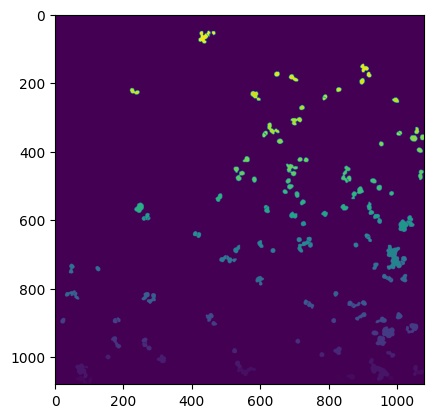

In [123]:
plt.imshow(prediction)

[0.00000000e+00 3.21243365e-04 3.97729880e-04 ... 9.99479892e-01
 9.99770540e-01 1.00000000e+00]


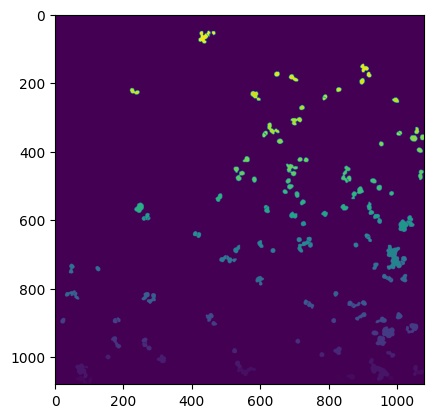

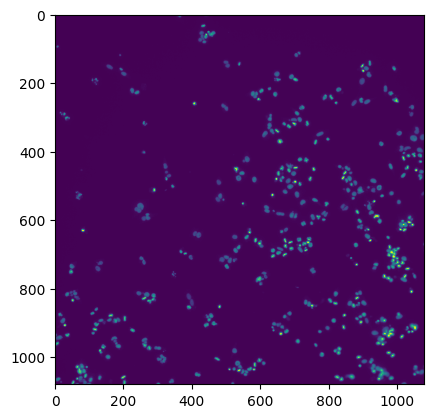

In [99]:
test_image = data_images_one[0]
test_image = normalise_image(test_image)
print(np.unique(test_image))
tiles, height, width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap = cut_image_into_tiles(test_image)
predictions = predict_tiles(unet, tiles)
result_image = reassemble_tiles(predictions, height, width, num_tiles_vertical, num_tiles_horizontal, pad_height, pad_width, tile_size, overlap)
#sigmoid result_image
result_image =  1 / (1 + np.exp(-result_image))
result_image = result_image > 0.5
result_image = binary_to_instance(result_image)
plt.imshow(result_image);plt.show()
plt.imshow(test_image);plt.show()  

In [100]:
print(np.unique(result_image, return_counts=True))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145]), array([1129167,     308,     184,     582,     289,     259,     682,
           286,    1558,     896,     287,     450,     156,     285,
           157,     165,     391,     161, 

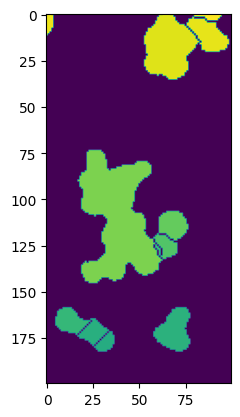

In [109]:
plt.imshow(result_image[600:800, 950:1050]);plt.show()

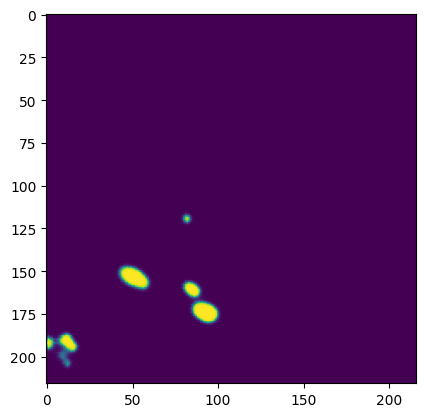

In [94]:
plt.imshow(1/(1+np.exp(-predictions[0][1])));plt.show()

In [35]:
256//2*9

1152

In [ ]:
#in terms of improving the model which we will keep to do for later here are some ideas
#1. smaller crops
#2. more data augmentations
#3. a loss which forces the model to learn the small cells
#4. batch normalisation

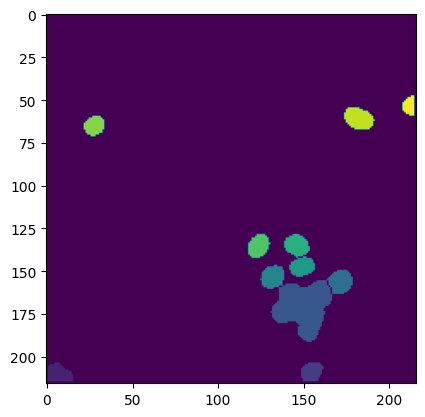

In [416]:
plt.imshow(result);plt.show()   

In [294]:
print(np.unique(image, return_counts=True))

(array([0., 1.]), array([49828, 90140], dtype=int64))


[0 1 2 3 4 5 6]


In [140]:
from skimage import measure

map_pred = map_pred>0.5
map_pred = map_pred.astype(np.uint8)
#map_pred = map_pred.squeeze(0)
map_pred = map_pred.cpu().detach().numpy()
instance = measure.label(map_pred)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
#need to implement the post-processing instance sgementation step
#need to implement the prediction function

#need to add the batch normalisation

#save model at checkpoint of new best validation IoU


In [97]:
print(val_IoU/len(validation_loader))

tensor(0.6062, device='cuda:0')
